<a href="https://colab.research.google.com/github/gyasifred/msc-thesis/blob/main/transformer__english_twi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is based on the implementation of the paper [Attention is All you Need](https://arxiv.org/abs/1706.03762) by Vaswani et al. (2017). The code are adapted from the Tenssorflow repository at https://www.tensorflow.org/text/tutorials/transformer#build_the_transformer and a big thanks to [[Crater David]](https://nrs.harvard.edu/URN-3:HUL.INSTREPOS:37370749) 


# Install tensorflow

In [23]:
!pip install -q -U tensorflow-text-nightly==2.11.0.dev20220817
!pip install -U -q tf-nightly==2.11.0.dev20220817
!pip3 install googletrans==3.1.0a0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import libraries

In [25]:
import tensorflow as tf
import tensorflow_text
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split

# preprocess data

In [26]:
# This code was adapted from https://github.com/GhanaNLP/kasa/blob/master/Kasa/Preprocessing.py
# A subclass of the kasafrench for preprocessing data
# import required library
import re
import unicodedata


class Preprocessing:
    # dummy initialization method
    def __init__(self):
        # initialize with some default parameters here later
        pass

    # read in parallel twi - english dataset
    def read_parallel_dataset(self, filepath_1, filepath_2, filepath_3=None):
        if filepath_3 != None:
            # read first language data
            lang_1 = []
            with open(filepath_1, encoding='utf-8') as file:
                line = file.readline()
                cnt = 1
                while line:
                    lang_1.append(line.strip())
                    line = file.readline()
                    cnt += 1

            # read second language data
            lang_2 = []
            with open(filepath_2, encoding='utf-8') as file:

                # twi=file.read()
                line = file.readline()
                cnt = 1
                while line:
                    lang_2.append(line.strip())
                    line = file.readline()
                    cnt += 1
            # Read third Language data
            lang_3 = []
            with open(filepath_3, encoding='utf-8') as file:
                line = file.readline()
                cnt = 1
                while line:
                    lang_3.append(line.strip())
                    line = file.readline()
                    cnt += 1

            return lang_1, lang_2, lang_3
            
        else:
            # read first language data
            lang_1 = []
            with open(filepath_1, encoding='utf-8') as file:
                line = file.readline()
                cnt = 1
                while line:
                    lang_1.append(line.strip())
                    line = file.readline()
                    cnt += 1

            # read second language data
            lang_2 = []
            with open(filepath_2, encoding='utf-8') as file:

                # twi=file.read()
                line = file.readline()
                cnt = 1
                while line:
                    lang_2.append(line.strip())
                    line = file.readline()
                    cnt += 1

            return lang_1, lang_2

    # Define a helper function to remove string accents

    def removeStringAccent(self, s):
        return ''.join(
            c for c in unicodedata.normalize('NFD', s)
            if unicodedata.category(c) != 'Mn'
        )

    # normalize input twi sentence
    def normalize_twi(self, s):
        s = self.removeStringAccent(s)
        s = s.lower()
        s = re.sub(r'([!.?])', r' \1', s)
        s = re.sub(r'[^a-zA-Z.ƆɔɛƐ!?’]+', r' ', s)
        s = re.sub(r'\s+', r' ', s)
        return s

    # normalize input french sentence
    def normalize_FrEn(self, s):
        s = self.removeStringAccent(s)
        s = s.lower()
        s = re.sub(r'([!.?])', r' \1', s)
        s = re.sub(r'[^a-zA-Z.!?]+', r' ', s)
        s = re.sub(r'\s+', r' ', s)
        return s
    
    def writeTotxt(self,destination,data):
        with open(destination, 'w') as f:
            for line in data:
                 f.write(f"{line}\n")

In [27]:
# import preprocessing class 
# Create an instance of tft preprocessing class
preprocessor = Preprocessing()

# Read raw parallel dataset
raw_data_twi, raw_data_en = preprocessor.read_parallel_dataset(
    filepath_1='/content/drive/MyDrive/verified_twi.txt',
    filepath_2='/content/drive/MyDrive/verified_english.txt'
)

# Normalize the raw data
raw_data_en = [preprocessor.normalize_FrEn(data) for data in raw_data_en]
raw_data_twi = [preprocessor.normalize_twi(data) for data in raw_data_twi]

# split data into training and test sets

In [28]:
# split the dataset into training and test sets
# Keep 10% of the data as test set
train_twi,test_twi,train_en,test_en = train_test_split(raw_data_twi,raw_data_en, test_size=0.1, random_state=42)

In [29]:
# write the preprocess traning and test dataset to a file
preprocessor.writeTotxt('train_twi.txt',train_twi)
preprocessor.writeTotxt('train_en.txt',train_en)
preprocessor.writeTotxt('test_twi.txt',test_twi)
preprocessor.writeTotxt('test_en.txt',test_en)

# Build tf dataset

In [30]:
# build tf datasets from traning and test sentences in both languages
train_dataset_en = tf.data.TextLineDataset('/content/train_en.txt')
train_dataset_tw = tf.data.TextLineDataset('/content/train_twi.txt')

val_dataset_en = tf.data.TextLineDataset('/content/test_en.txt')
val_dataset_tw = tf.data.TextLineDataset('/content/test_twi.txt')

In [31]:
# combine languages into single dataset
trained_combined = tf.data.Dataset.zip((train_dataset_en, train_dataset_tw))
val_combined = tf.data.Dataset.zip((val_dataset_en, val_dataset_tw))

In [32]:
# verify trained_combined dataset is correct
for en,tw in trained_combined.take(5):
  print("English: ", en.numpy().decode('utf-8'))
  print("Twi: ", tw.numpy().decode('utf-8'))

English:  the first american colonists arrived in the th century .
Twi:  amerika atubrafo a wodi kan no duu hɔ wɔ afeha a ɛto so no mu .
English:  you need to wash your hands .
Twi:  ɛsɛ sɛ wohohoro wo nsa .
English:  appiah horrow is payday .
Twi:  da a wɔde tua ka no yɛ da koro akatua .
English:  i can see why you like asamoah .
Twi:  mitumi hu nea enti a w ani gye asamoa ho
English:  he had jeans on .
Twi:  ɔhyɛ jeans attade


# load tokenizer



1. The tokenizer is which was build from the parallel corpus.
2. The code are available on the link https://colab.research.google.com/github/gyasifred/msc-thesis/blob/main/build_subword_tokenizer.ipynb


In [33]:
model_named = '/content/drive/MyDrive/translate_frengtwi_converter'
# Verify tokenizer model can be reloaded
tokenizers = tf.saved_model.load(model_named)

In [34]:
# Verify tokenizer works on french sentence
tokens = tokenizers.eng.tokenize(['I LOVE STUDENT LIFE'])
text_tokens = tokenizers.eng.lookup(tokens)
text_tokens

<tf.RaggedTensor [[b'[START]', b'i', b'love', b'student', b'life', b'[END]']]>

In [35]:
# Remove token markers to get original sentence
round_trip = tokenizers.eng.detokenize(tokens)
print(round_trip.numpy()[0].decode('utf-8'))

i love student life


In [36]:
# Verify tokenizer works on twi sentence
tokens = tokenizers.twi.tokenize(['Na mmarimaa ne mmeawa pii wɔ agudibea hɔ .'])
text_tokens = tokenizers.twi.lookup(tokens)
text_tokens

<tf.RaggedTensor [[b'[START]', b'na', b'mmarimaa', b'ne', b'mmeawa', b'pii', b'w\xc9\x94',
  b'agu', b'##di', b'##bea', b'h\xc9\x94', b'.', b'[END]']]>

In [37]:
# Remove token markers to get original sentence
round_trip = tokenizers.twi.detokenize(tokens)
print(round_trip.numpy()[0].decode('utf-8'))

na mmarimaa ne mmeawa pii wɔ agudibea hɔ .


# Check sentence with maximum length

By checking the maximum length of sentence, you can suitably select the MAX_TOKENS. The MAX_TOKKENS help drops examples longer than the maximum number of tokens (MAX_TOKENS). Without limiting the size of sequences, the performance may be negatively affected.




In [38]:
#The distribution of tokens per example in the dataset is as follows:

lengths = []

for twi_examples,en_examples in trained_combined.batch(50):
  twi_tokens = tokenizers.twi.tokenize(twi_examples)
  lengths.append(twi_tokens.row_lengths())

  en_tokens = tokenizers.eng.tokenize(en_examples)
  lengths.append(en_tokens.row_lengths())
  print('.', end='', flush=True)

..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................

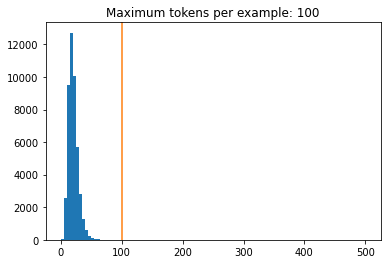

In [39]:
all_lengths = np.concatenate(lengths)

plt.hist(all_lengths, np.linspace(0, 500, 101))
plt.ylim(plt.ylim())
max_length = max(all_lengths)
plt.plot([max_length, max_length], plt.ylim())
plt.title(f'Maximum tokens per example: {max_length}');

# Tokenize the training and test sets

In [40]:
MAX_TOKENS = 50

def filter_max_tokens(l1, l2):
  num_tokens = tf.maximum(tf.shape(l1)[1],tf.shape(l2)[1])
  return num_tokens < MAX_TOKENS

In [41]:
# Routine to tokenize sentence pairs; needed to make sentence batches for training
def tokenize_pairs(en,twi):
  en = tokenizers.eng.tokenize(en)
  # Convert from ragged to dense, padding with zeros.
  en = en.to_tensor()
  tw = tokenizers.twi.tokenize(twi)
  # Convert from ragged to dense, padding with zeros.
  tw = tw.to_tensor()
  return en, tw

In [42]:
# create training batches
BUFFER_SIZE = len(train_twi)
BATCH_SIZE = 64
def make_batches(ds):
  return (
      ds
      .cache()
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(tokenize_pairs, num_parallel_calls=tf.data.AUTOTUNE)
      .filter(filter_max_tokens)
      .prefetch(buffer_size=tf.data.AUTOTUNE))

# Create training and validation set batches.
train_batches = make_batches(trained_combined)
val_batches = make_batches(val_combined)

Write the test batch to file. This will come in handy later if you prefer to translate from txt file and estimate the translator [BLEU](https://aclanthology.org/P02-1040.pdf) score. The translator will run to error for any for any sentence with the shape greater than the MAX_TOKENS used for training. It adivisable to use the trimmed sentences for testting to avoid such occurrance




In [43]:
en_test= []
twi_test = []

for en_batches,twi_batches in val_batches:
    for en in tokenizers.eng.detokenize(en_batches):
      en_test.append(en.numpy().decode("utf-8"))
    for tw in tokenizers.twi.detokenize(twi_batches):
      twi_test.append(tw.numpy().decode("utf-8"))


preprocessor.writeTotxt('/content/drive/MyDrive/twi_testing_set.txt',test_twi)
preprocessor.writeTotxt('/content/drive/MyDrive/english_testing_set.txt',en_test)


# Positional encoding


Positional encodings are added to the embeddings to give the model some information about the relative position of the tokens in the sentence so the model can learn to recognize the word order.



In [44]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates
  
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  # Apply the sine function to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # Apply the cosine function to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)

# Create a point-wise feed-forward network

In [45]:
def point_wise_feed_forward_network(
  d_model, # Input/output dimensionality.
  dff # Inner-layer dimensionality.
  ):

  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # Shape `(batch_size, seq_len, dff)`.
      tf.keras.layers.Dense(d_model)  # Shape `(batch_size, seq_len, d_model)`.
  ])

# Build Transformer

### Multihead Attention layer

In [46]:

# Create mask for padding tokens so translator ignores them
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)


# Mask future tokens so translator cannot see future
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)


# Create final masks
def create_masks(inp, tar):
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)
    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)
    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
    return enc_padding_mask, combined_mask, dec_padding_mask


def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead)
    but it must be broadcastable for addition.

    Args:
      q: query shape == (..., seq_len_q, depth)
      k: key shape == (..., seq_len_k, depth)
      v: value shape == (..., seq_len_v, depth_v)
      mask: Float tensor with shape broadcastable
            to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
      output, attention_weights
    """

    # (..., seq_len_q, seq_len_k)
    matmul_qk = tf.matmul(q, k, transpose_b=True)

    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(
        scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

# Add attention layers to create multi-head attention
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, *, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        # (batch_size, num_heads, seq_len_q, depth)
        q = self.split_heads(q, batch_size)
        # (batch_size, num_heads, seq_len_k, depth)
        k = self.split_heads(k, batch_size)
        # (batch_size, num_heads, seq_len_v, depth)
        v = self.split_heads(v, batch_size)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        # (batch_size, seq_len_q, num_heads, depth)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        # (batch_size, seq_len_q, d_model)
        output = self.dense(concat_attention)

        return output, attention_weights

        # Build Transformer encoder layer

### Encoder

In [47]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

    return out2

In [48]:
#Build Transformer encoder from encoder layer
class Encoder(tf.keras.layers.Layer):
  def __init__(self,num_layers, d_model, num_heads, dff, input_vocab_size,
              maximum_position_encoding=MAX_TOKENS,rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, rate=rate)
        for _ in range(num_layers)]

    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]

    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)

    return x  # (batch_size, input_seq_len, d_model)

### Decoder

In [49]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
    self.mha2 = MultiHeadAttention(d_model=d_model, num_heads=num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)

    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

    return out3, attn_weights_block1, attn_weights_block2

In [50]:
#Build Transformer decoder from decoder layer
class Decoder(tf.keras.layers.Layer):
  def __init__(self,num_layers, d_model, num_heads, dff, target_vocab_size,
              maximum_position_encoding,rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(target_vocab_size,d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, rate=rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}

    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)

      attention_weights[f'decoder_layer{i+1}_block1'] = block1
      attention_weights[f'decoder_layer{i+1}_block2'] = block2

    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

### Transformer

In [51]:
# Build full Transformer
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               target_vocab_size, pe_input=MAX_TOKENS, pe_target=MAX_TOKENS, rate=0.1):
    super(Transformer, self).__init__()
    self.encoder= Encoder(num_layers, d_model, num_heads, dff,input_vocab_size, pe_input, rate)
    self.decoder = Decoder(num_layers, d_model, num_heads, dff,target_vocab_size, pe_target, rate)
    self.final_layer = tf.keras.layers.Dense(target_vocab_size)
  
  def call(self, inp, tar, training, enc_padding_mask,look_ahead_mask, dec_padding_mask):
    enc_output = self.encoder(inp, training, enc_padding_mask) # (batch_size, inp_seq_len, d_model)
    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)
    final_output = self.final_layer(dec_output) # (batch_size, tar_seq_len, target_vocab_size)
    return final_output, attention_weights


# Optimizer and Metrics

In [52]:
# Set learning rate schedule

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)



loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
  accuracies = tf.equal(real, tf.argmax(pred, axis=2))

  mask = tf.math.logical_not(tf.math.equal(real, 0))
  accuracies = tf.math.logical_and(mask, accuracies)

  accuracies = tf.cast(accuracies, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

# Set hyperparameters

In [53]:
num_layers = 6
d_model = 512
dff = 2048
num_heads = 8
dropout_rate = 0.1

# Instantiate a Transformer


In [54]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers.eng.get_vocab_size().numpy(),
    target_vocab_size=tokenizers.twi.get_vocab_size().numpy(),
    rate=dropout_rate)

# Training

In [55]:
# Instantiate learning rate and set optimizer
learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,epsilon=1e-9)

In [56]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

In [57]:
checkpoint_path = './checkpoints/train'

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# If a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest checkpoint restored!!')

In [58]:
# Choose number of training epochs
EPOCHS = 120
train_step_signature = [
  tf.TensorSpec(shape=(None, None), dtype=tf.int64), 
  tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.
@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
  with tf.GradientTape() as tape:
    predictions, _ = transformer(inp, tar_inp,True,enc_padding_mask,combined_mask,dec_padding_mask)
    loss = loss_function(tar_real, predictions)
  gradients = tape.gradient(loss, transformer.trainable_variables)
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  train_loss(loss)
  train_accuracy(accuracy_function(tar_real, predictions))

In [59]:
%%time
# Run training! Each epoch takes several mins with GPU
for epoch in range(EPOCHS):
  start = time.time()

  train_loss.reset_states()
  train_accuracy.reset_states()

  # inp -> twi, tar -> french
  for (batch, (inp,tar)) in enumerate(train_batches):
    train_step(inp, tar)

    if batch % 50 == 0:
      print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')

  print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

Epoch 1 Batch 0 Loss 7.7623 Accuracy 0.0000
Epoch 1 Batch 50 Loss 7.0496 Accuracy 0.0681
Epoch 1 Batch 100 Loss 6.6273 Accuracy 0.0858
Epoch 1 Batch 150 Loss 6.3619 Accuracy 0.1017
Epoch 1 Batch 200 Loss 6.1123 Accuracy 0.1288
Epoch 1 Batch 250 Loss 5.9257 Accuracy 0.1486
Epoch 1 Batch 300 Loss 5.7860 Accuracy 0.1631
Epoch 1 Batch 350 Loss 5.6695 Accuracy 0.1747
Epoch 1 Loss 5.6568 Accuracy 0.1760
Time taken for 1 epoch: 83.58 secs

Epoch 2 Batch 0 Loss 4.8979 Accuracy 0.2524
Epoch 2 Batch 50 Loss 4.8272 Accuracy 0.2566
Epoch 2 Batch 100 Loss 4.8131 Accuracy 0.2577
Epoch 2 Batch 150 Loss 4.7570 Accuracy 0.2643
Epoch 2 Batch 200 Loss 4.7156 Accuracy 0.2679
Epoch 2 Batch 250 Loss 4.6602 Accuracy 0.2736
Epoch 2 Batch 300 Loss 4.6147 Accuracy 0.2783
Epoch 2 Batch 350 Loss 4.5760 Accuracy 0.2825
Epoch 2 Loss 4.5717 Accuracy 0.2829
Time taken for 1 epoch: 63.65 secs

Epoch 3 Batch 0 Loss 4.0894 Accuracy 0.3238
Epoch 3 Batch 50 Loss 4.1766 Accuracy 0.3226
Epoch 3 Batch 100 Loss 4.1318 Accurac

# Build a Translator


In [60]:
class Translator(tf.Module):
    def __init__(self, tokenizers, transformer):
        self.tokenizers = tokenizers
        self.transformer = transformer

    def __call__(self, sentence, max_length=MAX_TOKENS):
        # The input sentence is English, hence adding the `[START]` and `[END]` tokens.
        sentence = tf.convert_to_tensor([sentence])
        sentence = self.tokenizers.eng.tokenize(sentence).to_tensor()

        encoder_input = sentence

        # As the output language is TWI, initialize the output with the
        # English `[START]` token.
        start_end = self.tokenizers.twi.tokenize([''])[0]
        start = start_end[0][tf.newaxis]
        end = start_end[1][tf.newaxis]

        # `tf.TensorArray` is required here (instead of a Python list), so that the
        # dynamic-loop can be traced by `tf.function`.
        output_array = tf.TensorArray(
            dtype=tf.int64, size=0, dynamic_size=True)
        output_array = output_array.write(0, start)
        output = tf.transpose(output_array.stack())

        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
                encoder_input, output)

        for i in tf.range(max_length):
            output = tf.transpose(output_array.stack())

            enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
                encoder_input, output)

            predictions, attention_weights = self.transformer(
                encoder_input, output, False, enc_padding_mask, combined_mask, dec_padding_mask)

            # Select the last token from the `seq_len` dimension.
            # Shape `(batch_size, 1, vocab_size)`.
            predictions = predictions[:, -1:, :]

            predicted_id = tf.argmax(predictions, axis=-1)

            # Concatenate the `predicted_id` to the output which is given to the
            # decoder as its input.
            output_array = output_array.write(i+1, predicted_id[0])

            if predicted_id == end:
                break

        output = tf.transpose(output_array.stack())
        # The output shape is `(1, tokens)`.
        text = self.tokenizers.twi.detokenize(output)[0]  # Shape: `()`.

        tokens = self.tokenizers.twi.lookup(output)[0]
        _, attention_weights = self.transformer(
            encoder_input, output[:, :-1], False, enc_padding_mask, combined_mask, dec_padding_mask)

        return text, tokens, attention_weights

In [61]:
#Create an instance of this Translator class
translator = Translator(tokenizers, transformer)

## translate example sentecnes

In [62]:
def print_translation(sentence, tokens, ground_truth):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
  print(f'{"Ground truth":15s}: {ground_truth}')

In [63]:
sentence ="i ran to your brother on the street ."
ground_truth="mituu mmirika kɔɔ wo nua no nkyɛn wɔ abɔnten so ."
translated_text, translated_tokens, attention_weights = translator(sentence)
print_translation(sentence, translated_text, ground_truth)

Input:         : i ran to your brother on the street .
Prediction     : mituu mmirika kɔɔ wo nua no nkyɛn wɔ abɔnten so .
Ground truth   : mituu mmirika kɔɔ wo nua no nkyɛn wɔ abɔnten so .


In [64]:
ground_truth="mepɛ sɛ mibisa wo asɛm bi ."
sentence="i want to ask you a question ."
translated_text, translated_tokens, attention_weights = translator(tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : i want to ask you a question .
Prediction     : mepɛ sɛ mibisa wo asɛm bi .
Ground truth   : mepɛ sɛ mibisa wo asɛm bi .


# Save Translator

In [65]:
# class to export translator
class ExportTranslator(tf.Module):
  def __init__(self, translator):
    self.translator = translator

  @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
  def __call__(self, sentence):
    (result,
     tokens,
     attention_weights) = self.translator(sentence, max_length=MAX_TOKENS)

    return result


In [66]:
translator = ExportTranslator(translator)

In [67]:
translator(tf.constant("mepɛ sɛ minya afoforo anim dom .")).numpy()

b'mpena y\xc9\x9b \xc9\x94man bi .'

In [68]:
module_no_signatures_path = '/content/drive/MyDrive/twi_english_translator'
print('Saving model...')
tf.saved_model.save(translator, module_no_signatures_path)

Saving model...


In [69]:
reloaded = tf.saved_model.load(module_no_signatures_path)

In [70]:
reloaded('the computer is in the library .').numpy().decode("utf-8")

'kɔmputa no wɔ nhomakorabea hɔ .'

#BLEU

In [71]:
import nltk
import numpy as np
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction


class Bleu():
    def __init__(self, translator):
        self.translator = translator

    def get_bleuscore(self, testfile, referencefile, smothingfunction=None):
        if type(testfile) == str and type(referencefile) == str:
            # Open test file and read lines
            f = open(testfile, "r")
            hypothesis = f.readlines()
            f.close()
            # open refernce file and read lines
            f = open(referencefile, "r")
            reference = f.readlines()
            f.close()
        elif type(testfile) == list and type(referencefile) == list:
            hypothesis = testfile
            reference = referencefile
        else:
            print(f'File must be txt or python list')

        # check the length of our input sentence
        length = len(hypothesis)
        bleu_total = np.array([0., 0., 0.])
        weights = [(1./2, 1./2), (1./3, 1./3, 1./3),
                   (1./4, 1./4, 1./4, 1./4)]
        for i in range(length):
            hypothesis[i] = hypothesis[i]
            reference[i] = reference[i]
            groundtruth = reference[i].lower().replace(" ' ", "'").replace(" .", ".").replace(" ?", "?").replace(" !", "!")\
                .replace(' " ', '" ').replace(' "', '"').replace(" : ", ": ").replace(" ( ", " (")\
                .replace(" ) ", ") ").replace(" , ", ", ").split()
            groundtruth = [groundtruth]
            translated_text = self.translator(
                hypothesis[i]).numpy().decode("utf-8")
            # print("Translated Text: ", translated_text)
            # print("Ground Truth: ", reference[i])
            candidate = translated_text.replace(" ' ", "'").replace(" .", ".").replace(" ?", "?").replace(" !", "!")\
                .replace(' " ', '" ').replace(' "', '"').replace(" : ", ": ").replace(" ( ", " (")\
                .replace(" ) ", ") ").replace(" , ", ", ").split()
            bleu = np.array(sentence_bleu(
                groundtruth, candidate, weights, smoothing_function=smothingfunction))
            bleu_total += bleu

        return f'2-GRAMS: {bleu_total[0]/length}',f'3-GRAMS: {bleu_total[1]/length}',f'4-GRAMS: {bleu_total[2]/length}'

In [72]:
#iNSTANTIATE OBJECT OF BLEU CLASS AND IT SMOOTHING FUNCTION
smooth= SmoothingFunction()
bleu = Bleu(reloaded)

In [73]:
# ESTIMATE BLEU SCORE FROM THE TEST DATA
# from list
%%time
bleu.get_bleuscore(en_test,twi_test, smooth.method7)

CPU times: user 19min 23s, sys: 2min, total: 21min 23s
Wall time: 13min 2s


('2-GRAMS: 0.4048235573660457',
 '3-GRAMS: 0.299394570975767',
 '4-GRAMS: 0.22097535154160952')

GOOGLE *API* BLEU


In [74]:
# Use google API for bidirectional pivot translation of Twi and French
# pivot language = English
# import libraries
from googletrans import Translator, constants
# instantiate a translator object
# initiate translator object
translator = Translator()
# Add Akan to the language supported by this package
# Note the googletrans package has not  been updated to capture the new additions by google since May 2022
# from https://translate.google.com/?sl=en&tl=ak&op=translate , the key and value for Twi is 'ak':'akan'
constants.LANGUAGES['ak'] = 'akan'


class GooglePivot:
    def __init__(self):
        pass

    def evaluate(self, sentences, src_key, dest_key):
        eng_text = translator.translate(sentences, src=src_key, dest='en').text
        print(eng_text)
        output = translator.translate(eng_text, dest=dest_key).text

        return output


class GoogleDirect:
    def __init__(self):
        pass

    def evaluate(self, sentences, src_key, dest_key):

        return translator.translate(sentences, src=src_key, dest=dest_key).text

In [83]:
import nltk
import numpy as np
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction


class GoogleBleu():
    def __init__(self, translator):
        self.translator = translator

    def get_bleuscore(self, testfile, referencefile,src_lang,dest_lang, smothingfunction=None):
        if type(testfile) == str and type(referencefile) == str:
            # Open test file and read lines
            f = open(testfile, "r")
            hypothesis = f.readlines()
            f.close()
            # open refernce file and read lines
            f = open(referencefile, "r")
            reference = f.readlines()
            f.close()
        elif type(testfile) == list and type(referencefile) == list:
            hypothesis = testfile
            reference = referencefile
        else:
            print(f'File must be txt or python list')

        # check the length of our input sentence
        length = len(hypothesis)
        bleu_total = np.array([0., 0., 0.])
        weights = [(1./2, 1./2), (1./3, 1./3, 1./3),
                   (1./4, 1./4, 1./4, 1./4)]
        for i in range(length):
            hypothesis[i] = hypothesis[i]
            reference[i] = reference[i]
            groundtruth = reference[i].lower().replace(" ' ", "'").replace(" .", ".").replace(" ?", "?").replace(" !", "!")\
                .replace(' " ', '" ').replace(' "', '"').replace(" : ", ": ").replace(" ( ", " (")\
                .replace(" ) ", ") ").replace(" , ", ", ").split()
            groundtruth = [groundtruth]
            translated_text = self.translator.evaluate(hypothesis[i],src_key=src_lang, dest_key=dest_lang)
            # print("Translated Text: ", translated_text)
            # print("Ground Truth: ", reference[i])
            candidate = translated_text.replace(" ' ", "'").replace(" .", ".").replace(" ?", "?").replace(" !", "!")\
                .replace(' " ', '" ').replace(' "', '"').replace(" : ", ": ").replace(" ( ", " (")\
                .replace(" ) ", ") ").replace(" , ", ", ").split()
            bleu = np.array(sentence_bleu(
                groundtruth, candidate, weights, smoothing_function=smothingfunction))
            bleu_total += bleu

        return f'2-GRAMS: {bleu_total[0]/length}',f'3-GRAMS: {bleu_total[1]/length}',f'4-GRAMS: {bleu_total[2]/length}'

In [84]:
# instantiate GoogleDirect class
google_translate = GoogleDirect()

In [85]:
google_bleu = GoogleBleu(google_translate)

In [88]:
%%time
google_bleu.get_bleuscore(en_test, twi_test,'en','ak',smooth.method7)


CPU times: user 7.17 s, sys: 345 ms, total: 7.52 s
Wall time: 5min 7s


('2-GRAMS: 0.6066393340660294',
 '3-GRAMS: 0.48412228524019213',
 '4-GRAMS: 0.38535013926203615')